## Update historical stock price data (numerical time-series)

In [1]:
#ENHANCED 
# pip install yfinance
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# Step 1: Read the existing CSV file, ensuring to drop the 'Unnamed: 0' column if it exists
df_existing = pd.read_csv('../data/AAPLenhanced.csv').drop(columns=['Unnamed: 0'], errors='ignore')
df_existing['Date'] = pd.to_datetime(df_existing['Date']).dt.strftime('%Y-%m-%d')
last_date = pd.to_datetime(df_existing['Date']).max()

# Step 2: Fetch new data from Yahoo Finance
start_date = last_date + timedelta(days=1)  # Start fetching from the day after the last date
end_date = datetime.today().strftime('%Y-%m-%d')
ticker_aapl = 'AAPL'
ticker_gspc = '^GSPC'

# Fetch data for AAPL
df_new_aapl = yf.download(ticker_aapl, start=start_date, end=end_date)
df_new_aapl.reset_index(inplace=True)
df_new_aapl['Date'] = pd.to_datetime(df_new_aapl['Date']).dt.strftime('%Y-%m-%d')
df_new_aapl = df_new_aapl[['Date', 'Adj Close', 'Volume']]
df_new_aapl.rename(columns={'Adj Close': 'Adj.Close'}, inplace=True)

# Fetch data for GSPC
df_new_gspc = yf.download(ticker_gspc, start=start_date, end=end_date)
df_new_gspc.reset_index(inplace=True)
df_new_gspc['Date'] = pd.to_datetime(df_new_gspc['Date']).dt.strftime('%Y-%m-%d')
df_new_gspc = df_new_gspc[['Date', 'Adj Close']]
df_new_gspc.rename(columns={'Adj Close': 'GSPC.Adjusted'}, inplace=True)

# Merge the new data on the Date column
df_new = pd.merge(df_new_aapl, df_new_gspc, on='Date')

# Step 3: Merge the new data with the existing data
df_merged = pd.concat([df_existing, df_new], ignore_index=True)
df_merged.drop(columns=['SMA_50', 'rsi'], inplace=True)  # Drop the old columns

# Step 4: Recalculate SMA_50 and RSI
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the initial average gain and loss
    avg_gain = gain[:period].mean()
    avg_loss = loss[:period].mean()

    # Use these initial averages to calculate the rest of the averages
    avg_gain_values = [avg_gain]
    avg_loss_values = [avg_loss]
    
    for i in range(period, len(data)):
        avg_gain = (avg_gain * (period - 1) + gain[i]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i]) / period
        avg_gain_values.append(avg_gain)
        avg_loss_values.append(avg_loss)

    rs = pd.Series(avg_gain_values) / pd.Series(avg_loss_values)
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index[period - 1:]  # Align index with original data
    return rsi.reindex(data.index, method='pad')  # Reindex to original data length

df_merged['SMA_50'] = calculate_sma(df_merged['Adj.Close'], 50)
df_merged['rsi'] = calculate_rsi(df_merged['Adj.Close'], 14)

# Step 5: Save the merged dataset to a new CSV file
today_str = datetime.today().strftime('%Y-%m-%d')
df_merged.to_csv(f'../data/AAPL_{today_str}.csv', index=False)

[*********************100%%**********************]  1 of 1 completed
/var/folders/h2/h6g6fk252v76pst2bj55kwgw0000gn/T/ipykernel_29434/2695088141.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_aapl.rename(columns={'Adj Close': 'Adj.Close'}, inplace=True)
[*********************100%%**********************]  1 of 1 completed
/var/folders/h2/h6g6fk252v76pst2bj55kwgw0000gn/T/ipykernel_29434/2695088141.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_gspc.rename(columns={'Adj Close': 'GSPC.Adjusted'}, inplace=True)


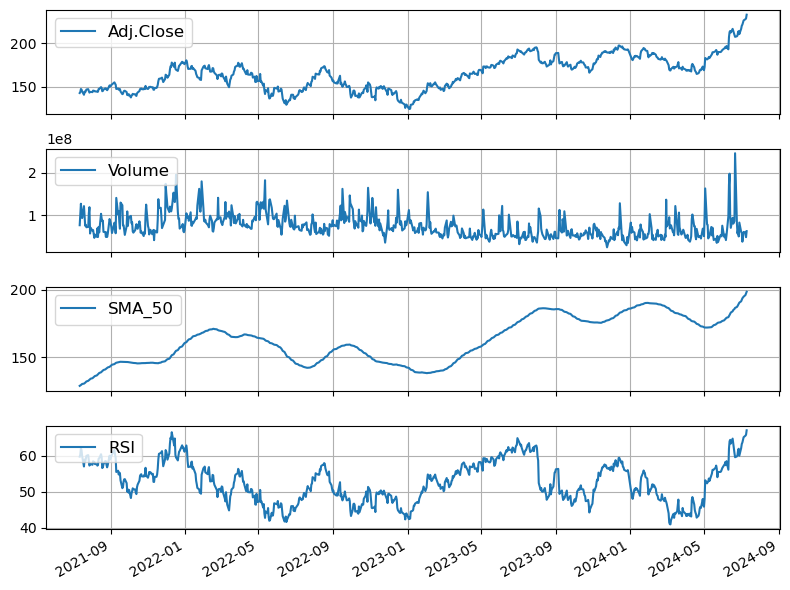

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the 'Date' column to datetime
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Filter the data for the last three months
three_months_ago = pd.to_datetime(end_date) - pd.DateOffset(months=36)
last_three_months_data = df_merged[df_merged['Date'] >= three_months_ago]

# Plot the data
fig, axs = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Plot Adjusted Close
axs[0].plot(last_three_months_data['Date'], last_three_months_data['Adj.Close'], label='Adj.Close')
axs[0].legend(fontsize=12, loc='upper left')

# Plot Volume
axs[1].plot(last_three_months_data['Date'], last_three_months_data['Volume'], label='Volume')
axs[1].legend(fontsize=12, loc='upper left')

# Plot SMA_50
axs[2].plot(last_three_months_data['Date'], last_three_months_data['SMA_50'], label='SMA_50')
axs[2].legend(fontsize=12, loc='upper left')

# Plot RSI
axs[3].plot(last_three_months_data['Date'], last_three_months_data['rsi'], label='RSI')
axs[3].legend(fontsize=12, loc='upper left')

# Set common labels
for ax in axs:
    ax.grid(True)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()